# Solving the Traveling Salesman Problem with Simulated Annealing

**by Filipe Chagas Ferraz**

![](tsp_sa_filipe.gif)

## Traveling Salesman Problem

The Traveling Salesman Problem (TSP) is a classic optimization problem where a salesman must visit a set of cities exactly once and return to the starting city, with the goal of minimizing the total travel distance or cost. Given the high number of possible routes as the number of cities grows, TSP is computationally challenging and is classified as an NP-hard problem. It has applications in logistics, manufacturing, and route planning, and is commonly solved using heuristic, approximation, or exact algorithms.

Formally, the TSP consists in finding, for a graph of $N$ points $\{p_1, p_2, ..., p_N\}$ and $N^2-N$ non-zero distances $\{d_{i,j}\}_{i \neq j}$, a closed path that connects all points with minimum total distance. It can be formulated as the following integer programming problem:

$$z' = \argmin_{z \in \mathbb{B}^{N\times N}} \left\{ \sum_s \sum_{i\neq j} d_{i,j} z_{(s-1,i)} z_{(s,j)} + \sum_{i \neq j} d_{i,j} z_{(N,i)} z_{(1,j)} \right\} $$

constrained by:

$$\forall_{1 \leq i < N}: \sum_s z_{(s,i)} = 1$$
$$\forall_{1 \leq s < N}: \sum_i z_{(s,i)} = 1$$

where $z_{(s,i)} \in \mathbb{B}$ is a binary variable that indicates whether the $s$-th step of the path corresponds to the $i$-th point of the graph.

As it is an NP-hard problem, there is no exact algorithm to solve it in tractable time. Therefore, in practice, instead of solving it exactly, we use metaheuristic optimization algorithms to obtain solutions that are good enough. In this notebook, the Simulated Annealing metaheuristic algorithm is used.

## Simulated Annealing

Simulated Annealing is an optimization algorithm inspired by the annealing process in metallurgy, where materials are slowly cooled to reach a stable state with minimal energy. The algorithm searches for an optimal solution by exploring possible solutions and occasionally accepting worse solutions to escape local optima. As the algorithm progresses, it gradually reduces the likelihood of accepting worse solutions, "cooling down" until it converges to a near-optimal solution. Simulated Annealing is widely used for solving complex optimization problems, especially when the solution space is large and contains many local minima (the case of TSP).

SA starts from an initial solution $x_0$ and iteratively moves through the solution space. In each iteration, a neighbor solution $x'$ is generated by making a small, random modification to the current solution $x$, ensuring that $x'$ remains feasible within the integer constraints of the problem. The objective function values, $f(x)$ and $f(x')$, are then evaluated to determine whether to accept the new solution.

The algorithm decides to move to $x'$ with a probability defined by the Metropolis criterion:

$$P(\text{accept}\ x') = \begin{cases}
    1, \qquad \qquad f(x') < f(x)\\
    e^{-\Delta/T}, \qquad f(x') \geq f(x)
\end{cases}$$

where $\Delta = f(x') - f(x)$ and $T$ is the current temperature, a parameter that gradually decreases over time. Higher temperatures make the algorithm more likely to accept worse solutions (i.e., those with $f(x') \geq f(x)$), allowing it to escape local minima. As $T$ decreases, the probability of accepting worse solutions also decreases, refining the search around promising regions.

To solve the TSP using Simulated Annealing, we define de objective function as
$$f(z) = \sum_s \sum_{i\neq j} d_{i,j} z_{(s-1,i)} z_{(s,j)} + \sum_{i \neq j} d_{i,j} z_{(N,i)} z_{(1,j)}$$

and define the transitions $x \mapsto x'$ as swaps between two random rows of $z$.

## Inplementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from random import randint

In the next cell, a set of $N$ points $(x,y)$ are created with random coordinates.

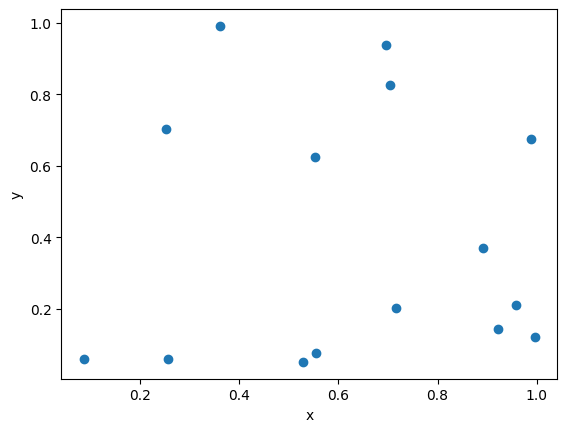

In [2]:
N = 15
points = np.random.random((N,2))

plt.scatter(points[:,0], points[:,1])
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In the next cell, a distance matrix is created with the euclidean distances of all pairs of points. 
$$\text{distances}[i,j] = \lVert p_i - p_j\rVert$$

In [ ]:
distances = np.array([[np.linalg.norm(points[i]-points[j]) for j in range(N)] for i in range(N)])

In the next cell, the objective function is defined.

$$\text{objective}(z) = \sum_s \sum_{i\neq j} d_{i,j} z_{(s-1,i)} z_{(s,j)} + \sum_{i \neq j} d_{i,j} z_{(N,i)} z_{(1,j)}$$

In [11]:
objective = lambda z: np.sum(
    [distances[i,j]*z[s-1,i]*z[s,j] for j in range(N) for i in range(N) for s in range(N)]
    + [distances[i,j]*z[-1,i]*z[0,j] for j in range(N) for i in range(N)]
    ) 

In the next cell, a function is defined to perform random transitions between feasible states $z \mapsto z'$. As explained above, this transition is made by swapping random rows of $z$.

In [5]:
def disturb(z):
    s1 = randint(0, N-2)
    s2 = randint(s1+1, N-1)
    z_ = z.copy()
    aux = z_[s1,:].copy()
    z_[s1,:] = z_[s2,:].copy()
    z_[s2,:] = aux
    return z_

In the next cell, a function is defined to generate an initial random feasible state $z_0$.

In [6]:
def init_state():
    z0 = np.eye(N)
    for i in range(N):
        z0 = disturb(z0)
    return z0

In the next cell, a function to perform the Simulated Annealing optimization is defined.

In [7]:
def anneal(z0, n_iterations, n_disturbances, n_success, alpha=0.9, update_f=None):
    # Simulated Annealing Function
    # Params:
    #   z0 (Numpy 2D array) - initial state
    #   n_iterations (int) - maximum number of annealing epochs
    #   n_disturbances (int) - maximum number of disturbances per epoch
    #   n_success (int) - maximum number of successful disturbances per epoch
    #   alpha (float) - temperature reduction factor
    #   update_f (callable) - callback function to call after each epoch
    z = z0.copy() # Current state

    temperature = 1000.0 # Current temperature
    
    for i in range(n_iterations): # Epochs
        success_count = 0
        
        for j in range(n_disturbances):
            z_trial = disturb(z)
            delta = objective(z_trial) - objective(z)
            
            if delta <= 0 or np.exp(-delta/temperature) > np.random.rand():
                z = z_trial
                success_count += 1
            
            if success_count >= n_success:
                break
        
        temperature *= alpha

        if update_f is not None:
            update_f(i, temperature, z)

        if success_count == 0: #Stuck in local minina
            break
    
    return z

In the next cell, the functions defined above are finally executed.

In [8]:
z0 = init_state()

loss_history = []
temperature_history = []
z_history = []

def update(epoch, temperature, z):
    z_history.append(z)
    loss_history.append(objective(z))
    temperature_history.append(temperature)

zf = anneal(z0, 1000, 100, 5, update_f=update)

In the next cell, the solution and the evolution of objective function values and temperature over time are plotted.

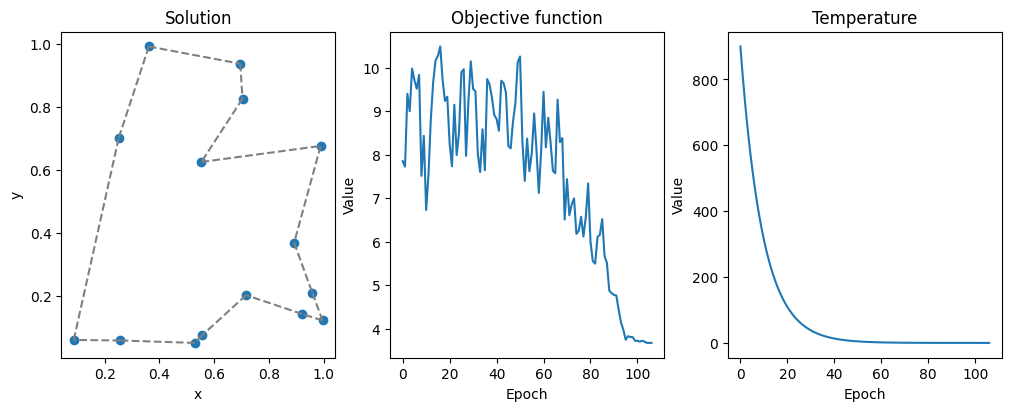

In [9]:
fig, ax = plt.subplots(ncols=3, figsize=(10,4), constrained_layout=True)

# --- Plot solution ---
for s in range(N-1):
    p1 = points[np.argmax(zf[s,  :]), :]
    p2 = points[np.argmax(zf[s+1,:]), :]
    ax[0].plot([p1[0], p2[0]], [p1[1], p2[1]], color='gray', linestyle='dashed')

p1 = points[np.argmax(zf[-1,:]), :]
p2 = points[np.argmax(zf[0, :]), :]
ax[0].plot([p1[0], p2[0]], [p1[1], p2[1]], color='gray', linestyle='dashed')
ax[0].scatter(points[:,0], points[:,1])
ax[0].set_title('Solution')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')

# --- Plot objective function values ---
ax[1].plot(loss_history)
ax[1].set_title('Objective function')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Value')

# --- Plot temperature values ---
ax[2].plot(temperature_history)
ax[2].set_title('Temperature')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Value')

plt.show()

In [10]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(figsize=(4,4))

# --- Plot initial state ---

chart_lines = []
for s in range(N-1):
    p1 = points[np.argmax(z0[s,  :]), :]
    p2 = points[np.argmax(z0[s+1,:]), :]
    chart_line, = ax.plot([p1[0], p2[0]], [p1[1], p2[1]], color='gray', linestyle='dashed')
    chart_lines.append(chart_line)

p1 = points[np.argmax(z0[-1,:]), :]
p2 = points[np.argmax(z0[0, :]), :]
chart_line, = ax.plot([p1[0], p2[0]], [p1[1], p2[1]], color='gray', linestyle='dashed')
chart_lines.append(chart_line)
ax.scatter(points[:,0], points[:,1])

def animate(k):
    z = z_history[k]
    for s in range(N-1):
        p1 = points[np.argmax(z[s,  :]), :]
        p2 = points[np.argmax(z[s+1,:]), :]
        chart_lines[s].set_data([p1[0], p2[0]], [p1[1], p2[1]])
    
    p1 = points[np.argmax(z[-1,:]), :]
    p2 = points[np.argmax(z[0,:]), :]
    chart_lines[-1].set_data([p1[0], p2[0]], [p1[1], p2[1]])

ani = FuncAnimation(fig, animate, frames=len(z_history), interval=50)
ani.save('tsp-sa-thumbnail.gif')
plt.close()

MovieWriter ffmpeg unavailable; using Pillow instead.
